### ============  How to compute like a brain ==========

#### ==============[ <a href='http://ifni.co'>HOME</a>  ]=====[ <a href='http://ifni.co/toc/programming'>Programming</a>  ]=====[ <a href='https://github.com/vsraptor/bbhtm'>Source code</a> ]=====

---

In [1]:
%matplotlib inline

import sys
sys.path.append('../lib')
sys.path.append('../lib/test')
import numpy as np
from data_test import *
from utils import *
import warnings
warnings.filterwarnings('ignore')

---

# Spatial Pooler/Mapper !

---

*In the main article we discussed somewhat the **Spatial pooler**, the thing is that the more I read about it and the more I ask about it on the mailing list, the more I got confused ... You too! Welcome to the club.*

*The implementation in the papers seem understandable, but nobody can tell me what the goals or expected behavior is. Or may be I'm too dumb to grasp them :/ .*

(Because I don't want to confuse what Numenta may expresses as **Spatial pooler** and what I will purpose here, I will use a different term instead : **Spatial mapper**. If it happens later that my interpretation is close to what Numenta call SP, then I will update the document).

*I was building and tossing away SP implementation after implementation ... on the surface every one of them looked feasable, but there were always some nagging feeling that something was not right !!*

*I was going nowhere, then an idea struck me. What if ..... And this is the theme of this article. Excited ??*

---

The **Spatial mapper** that I developed on abstract level looks at the problem of spatial patterns from different vantage point. That said we need a redefinition of our goals to solve this problem.
Here are our new goals :

- **The Data is king** : We need to represent as best as possible the specific real data we receive with the available bits (columns). 
- We need to make the output **SDR stable**, but adjust for new data as it comes in. Adapt.
- Solve the **"size-mismatch-impedance"** problem i.e. allow easy connections between Encoders, TM and so on.. even when their input and output sizes do not match. Act as a plumbing between TM's.  

Let's think abit, we receive a stream of SDRs and then we have to output consistent SDRs that go into Temporal Memory.
The input SDR to TM has a size of **n**, the space described by binary string of this size contains **2^n** possible values. This is humongous amount of possibilities. 
But the interesting part is that during the lifetime of a the signal most probably TM will receive/use only very small number of those possible combinations AND even when the number of combinations is bigger, if we have adaptive system which can change slowly as the data variability change i.e. make the output stabler then we will be OK.

As we discussed previously the input enters the **TM region** trough the columns vertically. Every column is single bit from the input-SDR.

Here is the breakthrough idea that finally broke my impasse :)

Let's assume a SDR with size 100 bits and let say we want to process signal of 1000 time steps **(t)** i.e. total of 1000 values.
The size of the space we use to represent every one of those values is 2^100, but in reality we would use only 1000 of those at most (if there are no repetitions). So question one is what we can do to conserve "bits".
Second we will need a metric to compare SDRs!
For this purpose we may use *overlap* as we did for TM or *hamming distance*. In this case we would use **hamming distance**.
(Hamming distance is so underrated in HTM theory ;) )

Next, what if for every one of the 100 bits (of our new representation) we create an bit-string **(Y)** of size **n** and use them as sort of "seekers" in this huge space to "chase"" the values coming into, using hamming distance to decide how close we are to the value-bitstring **(X)**.

We pass the values *{ x1,x2,x3 ... xt }* to the Spatial mapper one by one and then on every time step we adjust closest **y-SDRs** a little bit so that they become even closer (as measured by hamming distance).

Mnemonically this learning process will looks like this :

```
for x in values :
  win = find_closest_ys(x)
  for y in win :
    adjust y towards x
```

and visually it looks like the picture shown below.

<img src='imgs/hamming_space.svg' height=400px width=400px align=left> 

The dots represent the data. Every time new value pops up the closest circles move towards it. It is important to highlight that only the *closest circles* have to move, not all of them.

What I just explained closely resembles what is known in Computer science as Self-organized Maps (aka SOM).
The general difference again is that SOM is mostly used with real-valued data (remember NN) and here we use binaries, SOM uses euclidean distance to measure closeness here we use hamming distance.

The other requirement we have is find a way to predict/convert the value from Encoder for example in usable form for the TM.
It will work like this :

```
#calculate HD between the datum and all the bit-SDRs
for every row in Memory matrix : 
   hd[row] = hamming_distance(row,value)
   
#find the closest   
win_idxs = argsort( hd )[: winners_count ]

#the indexes tells us which bits of the output SDR will be ON
make_SDR(win_idxs)
```

Bingo !! That is the whole magic when we want to convert a value, it flashes the closest bits and that tells us which columns of TM get activated.

The learning process guarantees that 1000 values from 2^100 possible ones are best represented by the closest bits (2% of n in general case). 

Also as the new values come in the bits will drift to represent the most recent values better. You can also stop learning or slow down the rates of learning at some point if you don't want drifting/adaptation. 

---

## Lets test it


In the <a href='bbHTM.html' target='_blank'>TM document</a> I described a scenario where we passed the information directly from the **Encoder to the TM**, but now that we have *Spatial Mapper* figured out we can build full chain **Encoder => SM => TM**.

I already did that and integrated it into the Test framework, you just have to pass **ttype='sp_enc'** parameter when creating the test and **enc_data_size** if you have differing in-out sizes. (take time to look at the code, by default in this implementation SM is set to learn from the first 1000 elements and then it stops learning. I did this just for the expediency of the need to start testing asap to confirm my theory.).

In this first try we will use SM just as pass-trough i.e. the inputs/outputs have the same dimension :

> **[ :Encoder: 500]>-----<[500 :SM: 500]>-----<[500 :TM: ]**

In [2]:
dt = DataTest(data_set='ny')

In [3]:
dt.new_test(name='5x500', ttype='enc_sp', data_size=500, nrows=5)

In [4]:
dt.first.run(end=1000)

Adding data metrics with name : 5x500 


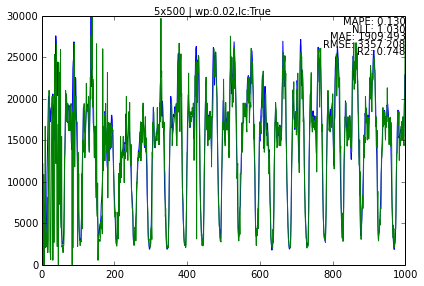

In [5]:
dt.first.plot_data()

Make sure you look at the full picture when you run it. There are cases when I get drop outs!!, haven't found the reason yet, could be SC.

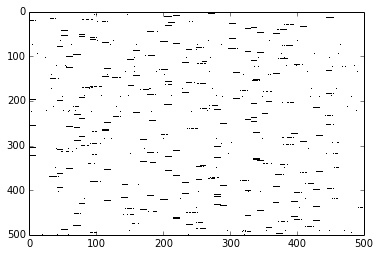

In [12]:
dt.first.sp.memory.show_mem()

Let's now create a test where the sizes of the SDR between modules differ.

> **[ :Encoder: 300]>-----<[300 :SM: 500]>-----<[500 :TM: ]**



In [8]:
dt.new_test(name='5x500e', ttype='enc_sp', enc_data_size=300, data_size=500, nrows=5)

Let's double check the signal input/output dimensions (n) :

In [9]:
dt.tests['5x500e'].se.info

> Scalar encoder -----
min-max/range : 0-30000/30000
buckets,width,n : 291,10,300



Thing to note which I haven't explained before is how Scalar classifier works by going trough all the values (in the range of what Scalar Encoder can transform) and generate the corresponding SDR. 
Later when we need to do reverse match i.e. convert from SDR back to Scalar we use overlap to decide which is the closest match.
The small tweak I added recently is that if Scalar-classifier detect Spatial Mapper is in use it will first encode the value and then will pass it trough the mapper. The reverse process is unaffected. neato ...

In [14]:
dt.tests['5x500e'].sc.info

> Scalar Classifier ==============================
range,step: 0 - 30000 , 10

> Scalar encoder -----
min-max/range : 0-30000/30000
buckets,width,n : 291,10,300

> 2D Bitmap -----
Dims in bits : 3000,500
Mem use : 0.18Mb
Fill %: 0.02%
Avg item % fill: 0.02%
Max item % fill: 0.02%



In [10]:
dt.tests['5x500e'].sp.info

> Spatial pooler =========================================
I => O size : 300 => 500
Rows, Cols : 500, 300
segment-size, in winc, out winc : 1, 6, 10
nudge : 5
> Memory =========================================
Data size : 300
rows,cols : 500, 300
win count : 6

> 2D Bitmap -----
Dims in bits : 500,300
Mem use : 0.02Mb
Fill %: 0.03%
Avg item % fill: 0.03%
Max item % fill: 0.04%



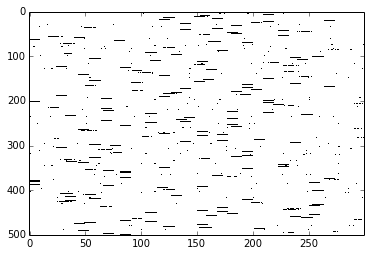

In [13]:
dt.tests['5x500e'].sp.memory.show_mem()

Do you see how the X-axis is 300 bits (input) and the Y-axis output is 500 bits (output).

Let's check that TM is also 500 bits.

In [11]:
dt.tests['5x500e'].tm.info

> Temporal Memory =========================================
Data size | number of columns : 500
Memory dims (rows,cols) : 5, 500
winc : 10

> Memory =========================================
Data size : 2500
rows,cols : 2500, 2500
win count : 50

> 2D Bitmap -----
Dims in bits : 2500,2500
Mem use : 0.75Mb
Fill %: 0.01%
Avg item % fill: 0.01%
Max item % fill: 0.02%



I think this is convincing enough for starters ;).

---

### Elaborations

**First** of all Spatial Mapper has almost no code !! The whole algorithm was moved to the Memory class (which is also very tiny), which can now use two different modes of representation and learning via OVERLAP or HAMMING DISTANCE ;).
The more I dig the better abstractions I seem to find.

**The bad news**, for now is that I have only tested the system with just Scalar Encoder (which is in reality still only Integer encoder :() and Scalar Classifier seems abit ad-hoc. I would have to figure better way of doing this especially when I add more Encoders, because there won't be always such an easy way to go back and forth. But one reason I postponed delving into it was that I needed the plumbing SM provides first, so that I can splice Encoders together to make compound types. 

**Very interesting**, SM solves the impedance-mismatch. now we can do the following :

- dimensional reduction or expansion anywhere in the chain.
- Chain multiple SM's with decreasing or increasing size.
- Splice outputs of Encoders, TM's or combinations of both anywhere in the hierarchy.
- Probably in some "permutation" SM can do or aid the job of the Temporal pooler.
- with small change to the algorithm you can pack multiple "interleaved" SM into single memory, thus doing complex information mixing. What about single SM acting in two directions, got ya :) 

Not bad.

**Now** let's talk about the similarity between SM and SOM.
SM is essentially SOM for the binary space. SOM has several tunable parameters :

- learning range (look code : nudge_step)
- faded learning rate (code : fade)
- learning rate decay
- learning range decay

Currently I only implemented the first two, the other ones require us to know in advance how "long" is the signal i.e. time steps, but HTM is streaming system so we don't know that.
It will be easy to add different behaviors, learn for up to **t** steps then decay and so on .... I leave this as exercise to the reader.

I don't know about you but **Spatial pooler** as defined in the papers to me look alot like SOM too, lets compare.

- The original SOM uses real values for data, real values for weights, and euclidean distance.
- The SP uses binary values for data, real values for permanence, and ?overlap? distance.
- The SM uses binary values for data, binary values for connection existence, and hamming distance.

**I will** probably add capability to represent column-bit by multiple seeker-SDR's instead just one, but haven't decided yet on the selection-algorithm for the winners. Currently "segment_size" option is unused, don't set it to anything different than 1 yet. Also "drifting" towards the value is randomly flipping bits that don't match between the two, may be we can use some more directed method (something like Stochastic gradient descent in NN to do it faster. We may not need it ! dunno.).

---

## Conclusions

The way the code is structured, look at it. Did you ?

May be you can probably guess the next logical step ! Right! No ?

> What if we implement TM using **hamming distance**, instead of **union-SDR** :).

No more need for forgetting-mechanism.
Also we will consolidate the algorithm and probably merge SM and TM into single implementation Spatio-Temporal Memory. You heard it here first :) 

I wish I can dig into this asap, but I'm sort of behind on more sophisticated testing.
The testing framework is sort of ad-hoc-ish, I've build it on the fly as the needs arise.  
And there are so many ways now to chain multiple modules, so many combinations to test and testing is boring, urghhh ....

But even before that may be I should add some more Encoders first !!! Decisions, decisions ...

*On another note, is the SM output stable enough so we can use it in/as TP ?*